<a href="https://colab.research.google.com/github/oguz81/MachineLearning/blob/main/stackoverflowclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# A basic ML model to classify stackoverflow questions.
# This is an exercise about text classification from tensorflow.org
# The model predicts which programming language stackoverflow questions are about.
# Oguz D. 1/7/24

import tensorflow as tf
import os
import re
import shutil
import string
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import losses
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')


In [ ]:
train_dir = os.path.join(os.path.dirname(dataset), 'train')
os.listdir(train_dir)

['java', 'javascript', 'csharp', 'python']

In [ ]:
test_dir = os.path.join(os.path.dirname(dataset), 'test')
os.listdir(test_dir)

['java', 'javascript', 'csharp', 'python']

In [ ]:
sample_file = os.path.join(train_dir, 'csharp/3.txt')
with open(sample_file) as f:
  print(f.read())

"how to extract the local time from gsm sim card by a gsm modem is there any method to extract the time from sim card in blank? i am using it as a alternate for time synchronization where internet is not present....  //----------- edit 1 ----------------------------------- till now i.  have tried gsm library for sending and receiving of sms. but it doesnt.  have any support to get time. i am using visual studio 2010, win form..  its a pure desktop application...kindly please dont close the question. its a straight forward question, all i am getting the time from sim card."



In [ ]:
batch_size = 64
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Question", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Question b'"unboundlocalerror: pygame music play and stop not working (on keydown) i\'m trying to play and stop a music in my main page...it\'s kind of weird..from my code,.if the user press ""m"", suppose, the music should be off..however, the music didn\'t off. it continue..unboundlocalerror: local variable \'music_playing\' referenced before assignment  ...can someone help me with my code?..pickupsound = pygame.mixer.music.load(\'test.mp3\').pygame.mixer.music.play(-1).music_playing = true..def mainmenu():.    main = pygame.image.load(\'menu.jpg\').    screen.blit(main,(0,0)).    while true:.        pygame.display.update().        for event in pygame.event.get():.            if event.type == pygame.quit:.                pygame.quit().                quit().            if event.type == keydown:.                if event.key == ord(\'m\'):.                    if music_playing:.                        pygame.mixer.music.stop().                    else:.                        pygame.mix

In [ ]:
print("Label 0 is ", raw_train_ds.class_names[0])
print("Label 1 is ", raw_train_ds.class_names[1])
print("Label 2 is ", raw_train_ds.class_names[2])
print("Label 3 is ", raw_train_ds.class_names[3])

Label 0 is  csharp
Label 1 is  java
Label 2 is  javascript
Label 3 is  python


In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test',
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


In [ ]:
vectorize_layer = layers.TextVectorization(
    standardize=None,
    max_tokens=1000,
    output_mode='int',
    output_sequence_length=250
)

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized question", vectorize_text(first_question, first_label))

Question tf.Tensor(b'"simple program not giving desired output i am starting to learn blank and i have a simple program to request two numbers from the user and add them together. when i run my program , i get asked for the first number , i type it in and that\'s it, the program doesn\'t go any further. i am running it in visual studio..can anyone tell me what i\'m doing wrong? ..using system;..namespace coding.{.    class program.    {.        static void main(string[] args).        {..            int number1;.            int number2;.            int result;...            console.writeline(""enter first  number to be calculated"");.            number1 = convert.toint32(console.readline());...            console.writeline(""enter second  number to be calculated"");.            number2 = convert.toint32(console.readline());..            result = number1 + number2;.            console.writeline(""the total is"" + "" "" + result);.        }.    }.}...result screenshot"\n', shape=(), dtype

In [ ]:
print("75-->", vectorize_layer.get_vocabulary()[75])

75--> method


In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
embedding_dim = 16
model = tf.keras.Sequential([
    layers.Embedding(1000, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4, activation='relu')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 16)          16000     
                                                                 
 dropout_12 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_6  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 4)                 68        
                                                                 
Total params: 16068 (62.77 KB)
Trainable params: 16068 (62.77 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
epochs = 60
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/60
100/100 [==============================] - 2s 10ms/step - loss: 1.3828 - accuracy: 0.3222 - val_loss: 1.3785 - val_accuracy: 0.3494
Epoch 2/60
100/100 [==============================] - 1s 12ms/step - loss: 1.3725 - accuracy: 0.3897 - val_loss: 1.3646 - val_accuracy: 0.3825
Epoch 3/60
100/100 [==============================] - 1s 14ms/step - loss: 1.3543 - accuracy: 0.4467 - val_loss: 1.3419 - val_accuracy: 0.4694
Epoch 4/60
100/100 [==============================] - 1s 15ms/step - loss: 1.3303 - accuracy: 0.4839 - val_loss: 1.3151 - val_accuracy: 0.5119
Epoch 5/60
100/100 [==============================] - 1s 9ms/step - loss: 1.3027 - accuracy: 0.4997 - val_loss: 1.2851 - val_accuracy: 0.5294
Epoch 6/60
100/100 [==============================] - 1s 9ms/step - loss: 1.2717 - accuracy: 0.5234 - val_loss: 1.2522 - val_accuracy: 0.5519
Epoch 7/60
100/100 [==============================] - 1s 9ms/step - loss: 1.2389 - accuracy: 0.5420 - val_loss: 1.2182 - val_accuracy: 0.5788
Ep

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

125/125 [==============================] - 0s 2ms/step - loss: 0.6265 - accuracy: 0.7580
Loss:  0.626466691493988
Accuracy:  0.7580000162124634


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

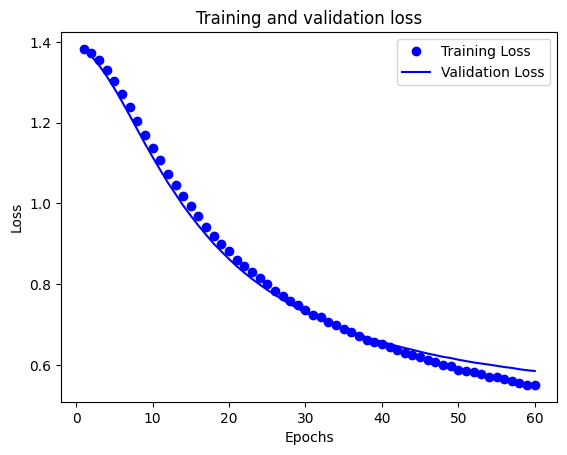

In [ ]:
acc = history_dict['accuracy'] # the word 'accuracy' is inside the dict_keys.
val_acc = history_dict['val_accuracy'] # and this 'val_accuracy' too.
loss = history_dict['loss'] # and so on.
val_loss = history_dict['val_loss'] # so on.

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b' ,label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



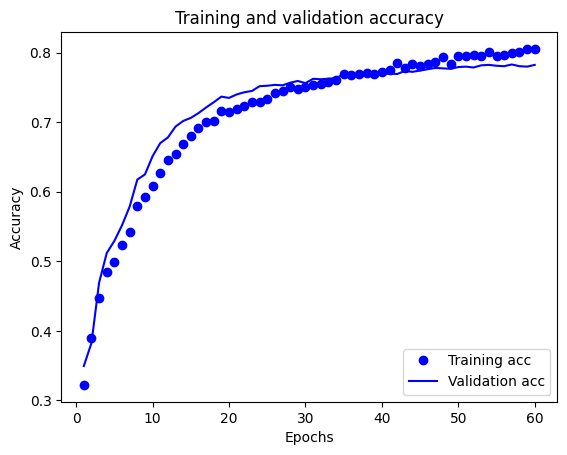

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()